In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import random
import pandas as pd
import pickle
import os
import pyproj
from shapely.geometry import Point, LineString
from datetime import datetime, timedelta
import ast
from geopy.distance import geodesic
from polyline import decode as decode_polyline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from datetime import date

today_date = date.today()
prior_day = today_date - timedelta(days=10)

In [2]:
prior_day

datetime.date(2024, 6, 2)

In [3]:
df_ml = pd.read_csv('C:\\Users\\Camelia\\Desktop\\app\\Disertatie\\ML\\MLDatasetUntil_'+prior_day.strftime("%Y-%m-%d")+'.csv')

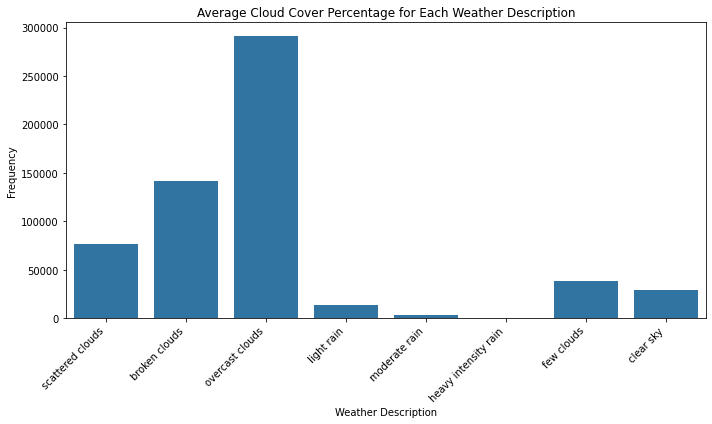

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ml, x='weather_data')
plt.title('Average Cloud Cover Percentage for Each Weather Description')
plt.xlabel('Weather Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

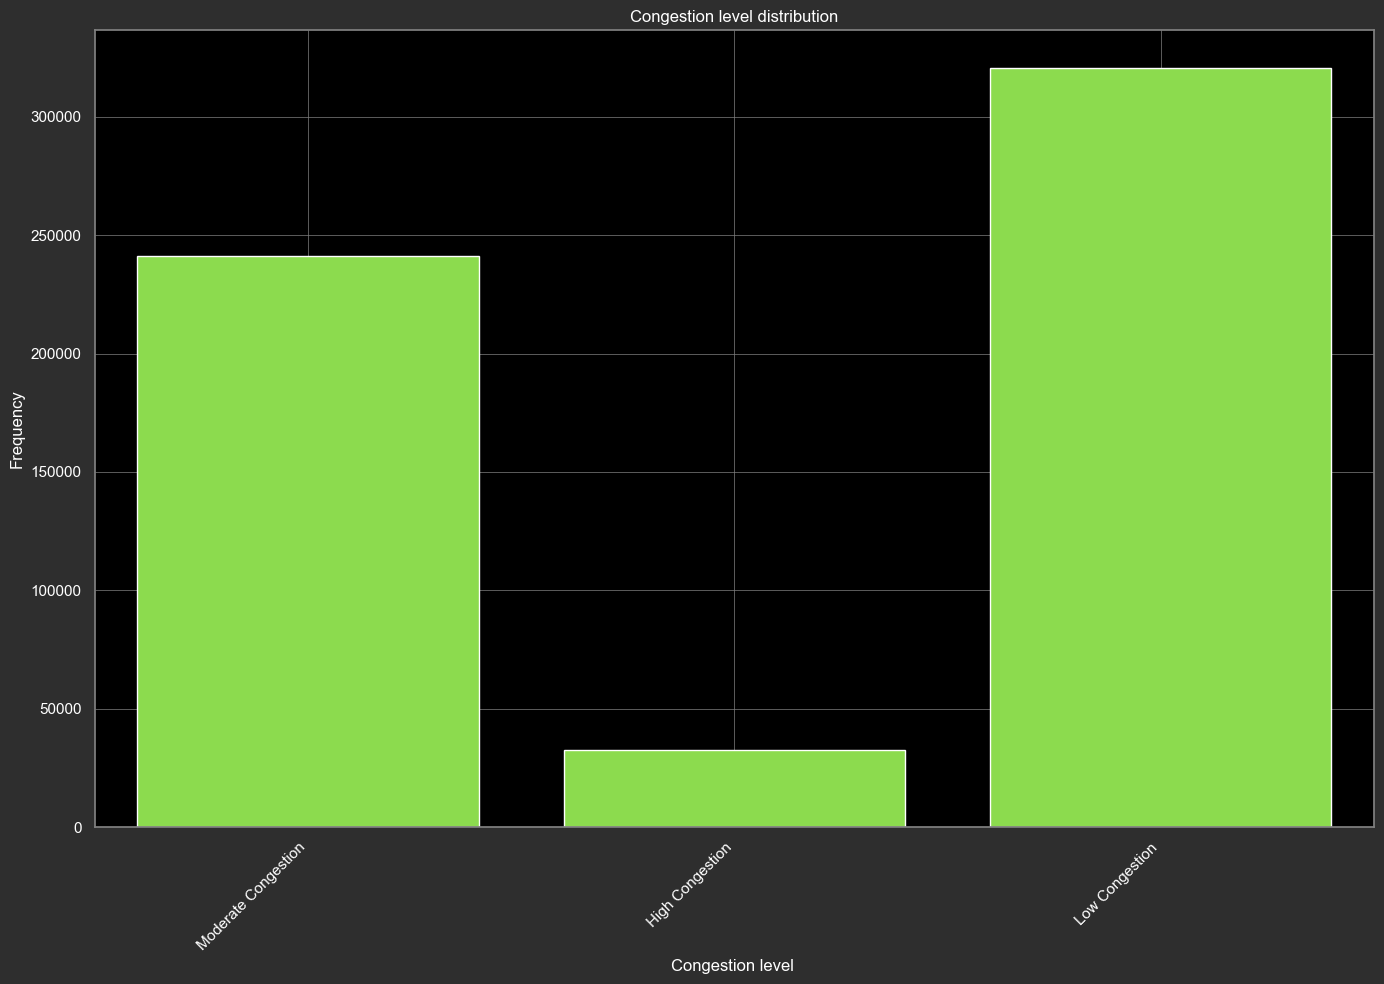

In [95]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.countplot(data=df_ml, x='congestion_level', color='#89f336')
plt.title('Congestion level distribution')
plt.xlabel('Congestion level ')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
plt.tight_layout()
# Change the color of the spines to grey
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()

In [4]:
df_merged = pd.read_csv('C:\\Users\\Camelia\\Desktop\\app\\Disertatie\\GeneticAlg\\MergedUntil_'+prior_day.strftime("%Y-%m-%d")+'.csv')

In [113]:
len(df_merged)

32769

In [5]:
# Reset to default style
plt.style.use('default')
sns.set_theme()

In [6]:

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'],errors='coerce')
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['duration_in_traffic_numeric'] = df_merged['duration_in_traffic'].str.extract('(\d+)').astype(int)
df_merged['duration_text_numeric'] = df_merged['duration_text'].str.extract('(\d+)').astype(int)
# Normalize congestion ratio using Min-Max normalization
df_merged['congestion_ratio'] = ((df_merged['duration_in_traffic_numeric'] - df_merged['duration_text_numeric']) / df_merged['duration_text_numeric'])

min_ratio = df_merged['congestion_ratio'].min()
max_ratio = df_merged['congestion_ratio'].max()
#df_merged['normalized_congestion'] = (df_merged['congestion_ratio'] - min_ratio) / (max_ratio - min_ratio)
df_merged['normalized_congestion']  = df_merged['congestion_ratio'] + abs(df_merged['congestion_ratio'].min())
# Filter data for weekdays and evening hours
filtered_data = df_merged[(df_merged['hour'].between(6, 22)) & (df_merged['timestamp'].dt.dayofweek < 5)].copy()
hourly_congestion = filtered_data.groupby(['origin_osmid','destination_osmid', 'hour','day_of_week'])['normalized_congestion'].mean().reset_index()
hourly_congestion['day_of_week'] = hourly_congestion['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'})
# Define the desired order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']



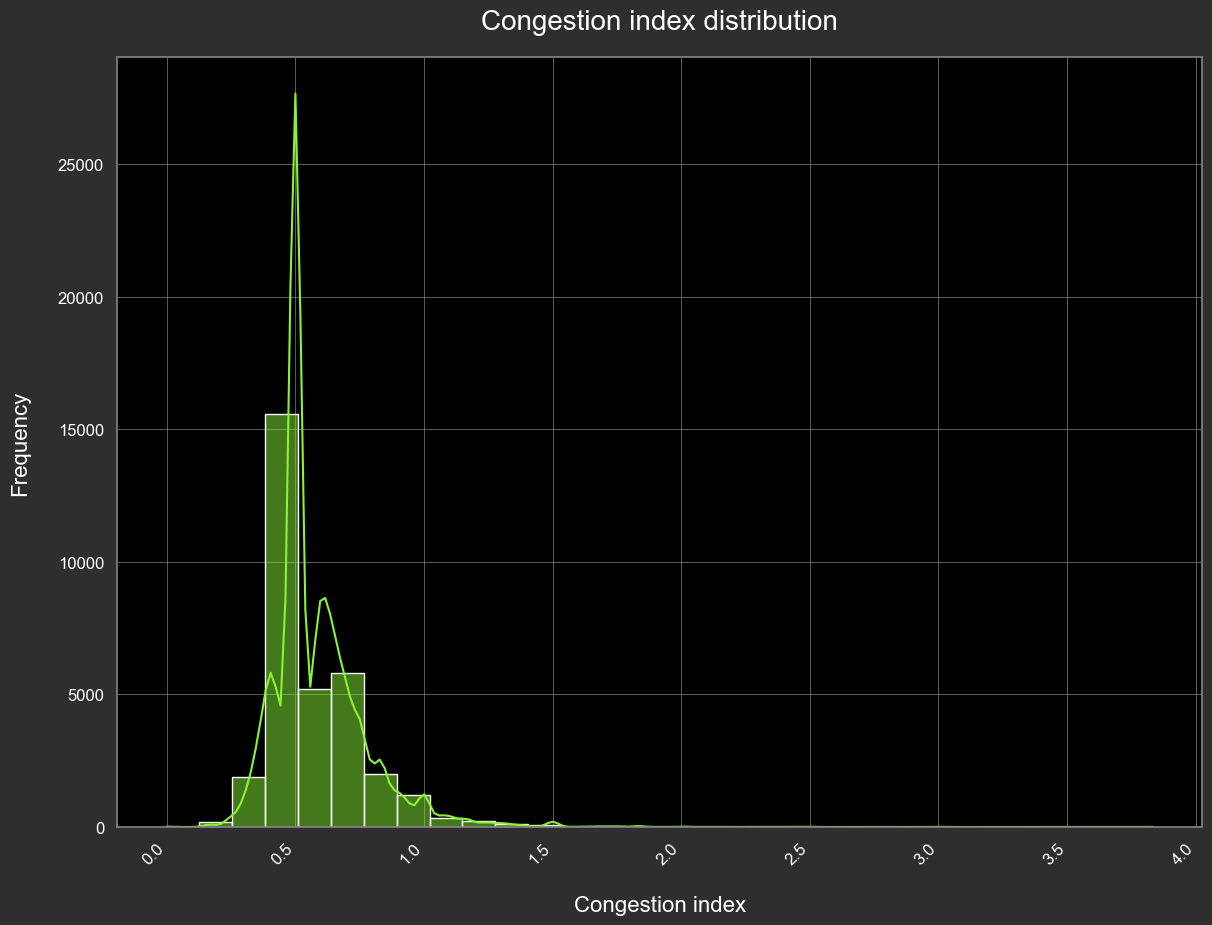

In [112]:
fig, ax = plt.subplots(figsize=(14, 10))
plt.style.use('dark_background')
# Plot the histogram with improved aesthetics
sns.histplot(data=df_merged, x='normalized_congestion', color='#89f336', kde=True, bins=30)

# Title and labels
plt.title('Congestion index distribution', fontsize=20, color='white', pad=20)
plt.xlabel('Congestion index', fontsize=16, color='white', labelpad=20)
plt.ylabel('Frequency', fontsize=16, color='white', labelpad=20)

# Set ticks parameters
plt.xticks(fontsize=12, color='white', rotation=45, ha='right')
plt.yticks(fontsize=12, color='white')

# Set grid color and style
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)

# Set figure background color
fig.patch.set_facecolor('#2E2E2E')


# Change the color of the spines to grey
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

# Show the plot
plt.show()

In [121]:
 # Calculate quartiles and median
Q1 = np.percentile(df_merged['normalized_congestion'], 25)
Q3 = np.percentile(df_merged['normalized_congestion'], 75)
#median = df_scaled[scoretype].median()
IQR= Q3-Q1
median = df_merged['normalized_congestion'].median()
congestion_bins = [df_merged['normalized_congestion'].min()-1e-6, median, Q3, df_merged['normalized_congestion'].max()]
congestion_labels = ['Low Congestion', 'Moderate Congestion', 'High Congestion']
# Create categorical variables
df_merged['congestion_level'] = pd.cut(df_merged['normalized_congestion'], bins=congestion_bins, labels=congestion_labels)

In [122]:
Q3

0.6666666666666666

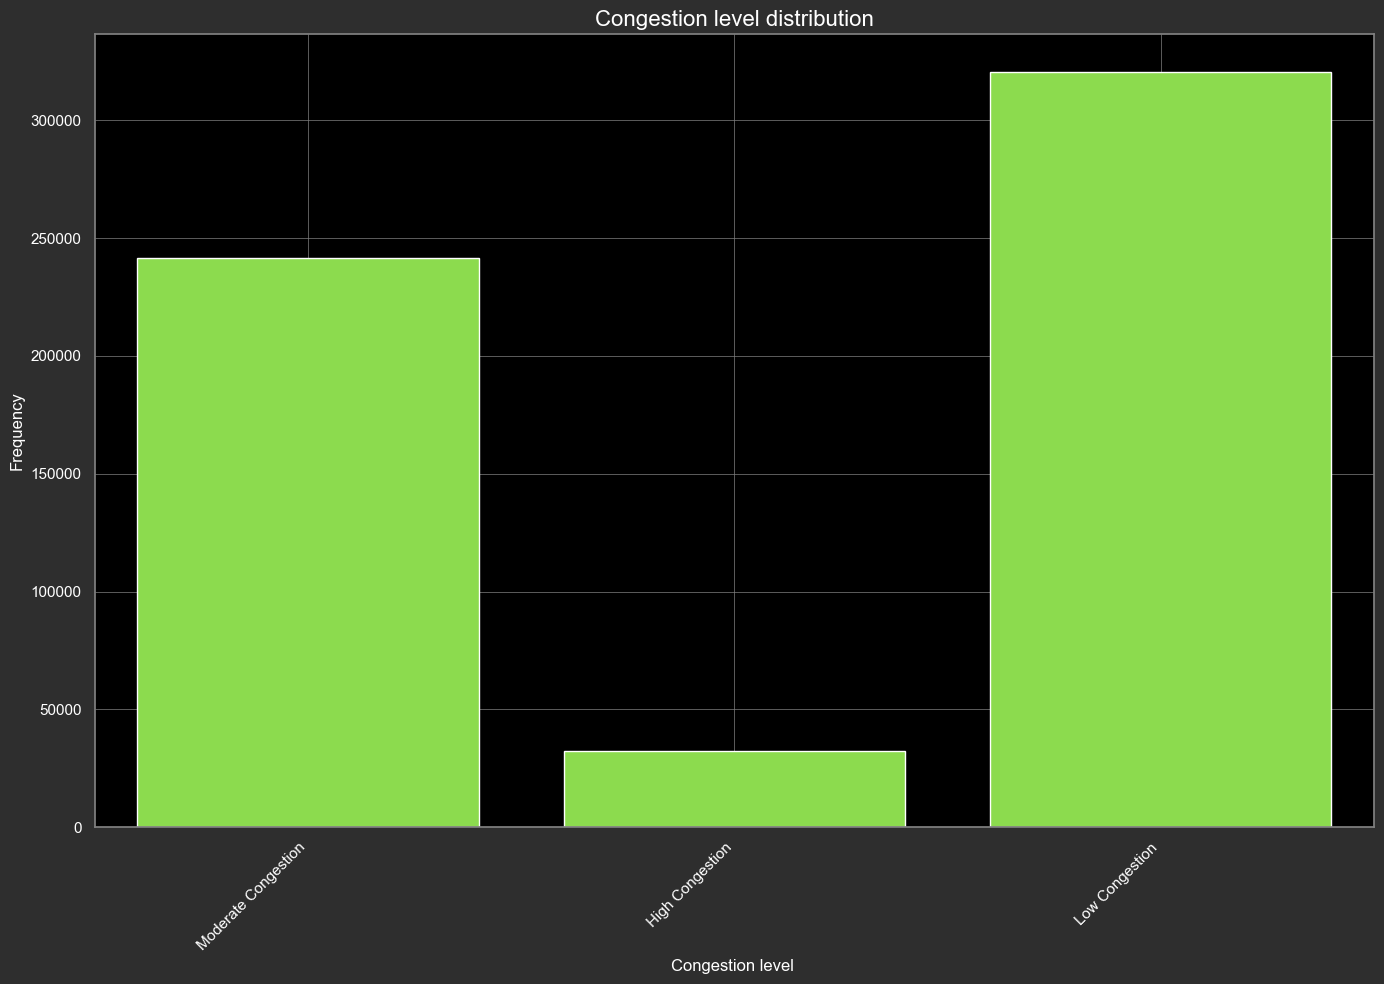

In [130]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.countplot(data=df_ml, x='congestion_level', color='#89f336')
plt.title('Congestion level distribution',fontsize=16)
plt.xlabel('Congestion level ')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
plt.tight_layout()
# Change the color of the spines to grey
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()

C:\Users\Camelia\AppData\Local\Temp/ipykernel_18304/4176798210.py:5: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order, palette=vibrant_colors,linewidth=2.5,errorbar=('ci', 95), alpha=0.7)


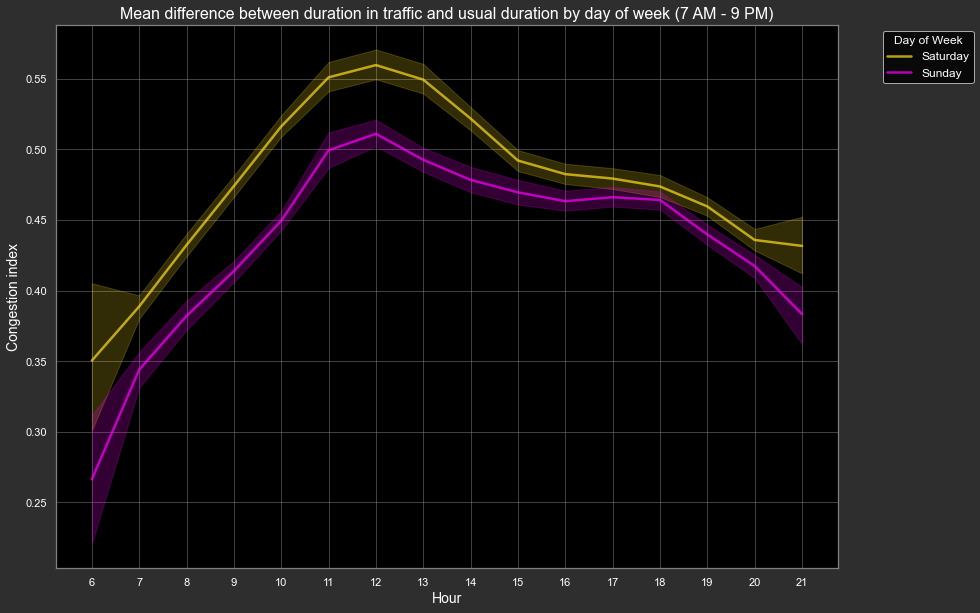

In [9]:

# Plot data using Seaborn with improved visibility
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 10))
vibrant_colors = ['#ffde21', '#ff00ff', '#FE6414', '#039BE5', '#89f336']
sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order, palette=vibrant_colors,linewidth=2.5,errorbar=('ci', 95), alpha=0.7)
plt.title('Mean difference between duration in traffic and usual duration by day of week (7 AM - 9 PM)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Congestion index', fontsize=14)
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
plt.xticks(range(6, 22))  # Set x-axis ticks from 7 PM to 9 PM
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
# Change the color of the spines to grey
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()

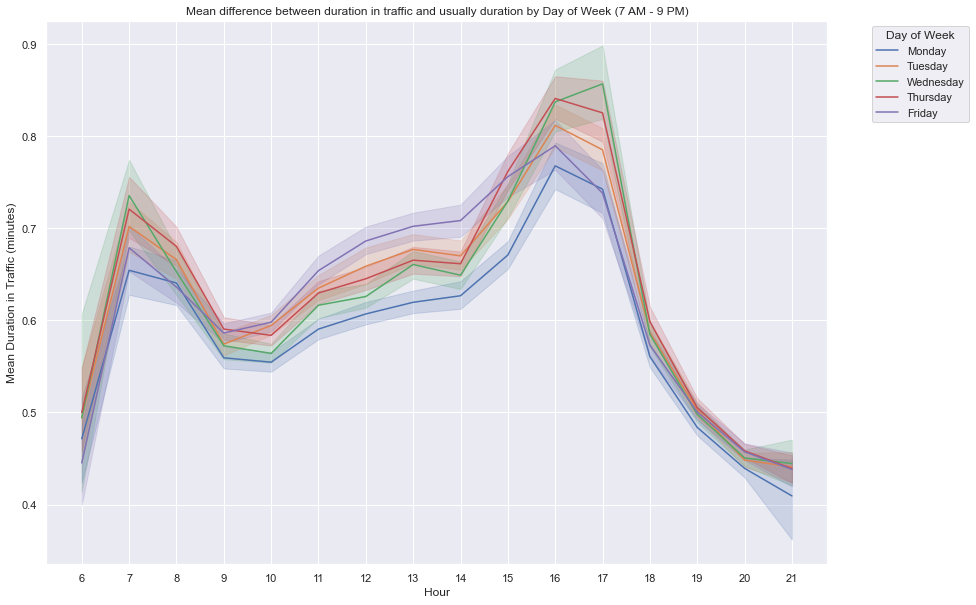

In [7]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'],errors='coerce')
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['duration_in_traffic_numeric'] = df_merged['duration_in_traffic'].str.extract('(\d+)').astype(int)
df_merged['duration_text_numeric'] = df_merged['duration_text'].str.extract('(\d+)').astype(int)
# Normalize congestion ratio using Min-Max normalization
df_merged['congestion_ratio'] = ((df_merged['duration_in_traffic_numeric'] - df_merged['duration_text_numeric']) / df_merged['duration_text_numeric'])

min_ratio = df_merged['congestion_ratio'].min()
max_ratio = df_merged['congestion_ratio'].max()
#df_merged['normalized_congestion'] = (df_merged['congestion_ratio'] - min_ratio) / (max_ratio - min_ratio)
df_merged['normalized_congestion']  = df_merged['congestion_ratio'] + abs(df_merged['congestion_ratio'].min())
# Filter data for weekdays and evening hours
filtered_data = df_merged[(df_merged['hour'].between(6, 22)) & (df_merged['timestamp'].dt.dayofweek < 5)].copy()
hourly_congestion = filtered_data.groupby(['origin_osmid','destination_osmid', 'hour','day_of_week'])['normalized_congestion'].mean().reset_index()
hourly_congestion['day_of_week'] = hourly_congestion['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'})
# Define the desired order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
# Plot data using Seaborn
plt.figure(figsize=(14, 10))
sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order)
plt.title('Mean difference between duration in traffic and usually duration by Day of Week (7 AM - 9 PM)')
plt.xlabel('Hour')
plt.ylabel('Mean Duration in Traffic (minutes)')
plt.grid(True)
plt.xticks(range(6, 22))  # Set x-axis ticks from 7 PM to 9 PM
#plt.ylim(0.35, 2)  # Set y-limits from 0 to 1
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


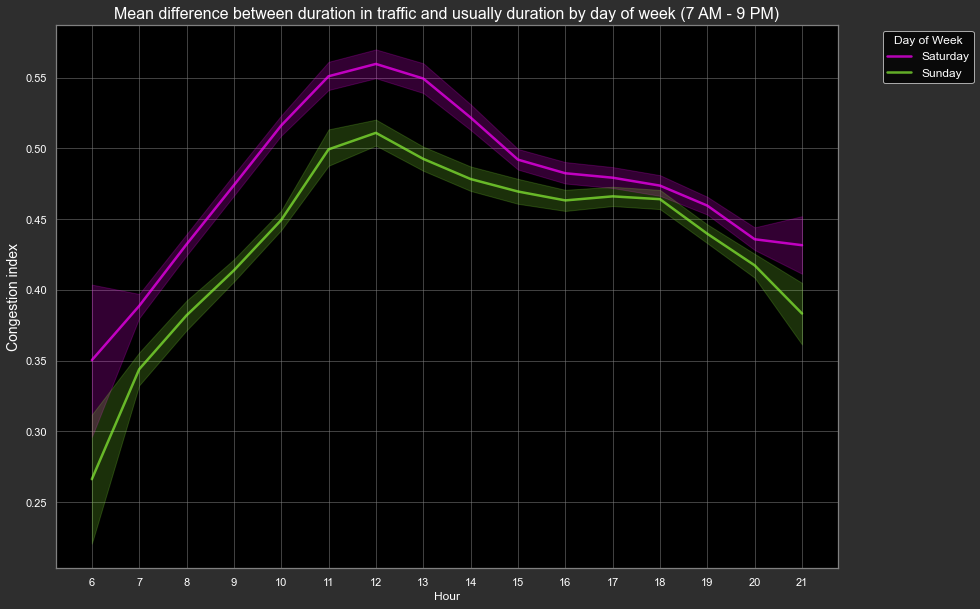

In [11]:
# ilter data for weekdays and evening hours
filtered_data = df_merged[(df_merged['hour'].between(6, 21)) & (df_merged['timestamp'].dt.dayofweek >= 5)].copy()
# Time-based aggregation
hourly_congestion = filtered_data.groupby(['origin_osmid','destination_osmid', 'hour','day_of_week'])['normalized_congestion'].mean().reset_index()
hourly_congestion['day_of_week'] = hourly_congestion['day_of_week'].map({5: 'Saturday', 6: 'Sunday'})
# Define the desired order of days of the week
day_order = ['Saturday', 'Sunday']
#######################################################################
vibrant_colors = ['#ff00ff', '#89f336']
fig, ax = plt.subplots(figsize=(14, 10))
sns.lineplot(data=hourly_congestion, x='hour', y='normalized_congestion', hue='day_of_week', hue_order=day_order, palette=vibrant_colors,linewidth=2.5,errorbar=('ci', 95), alpha=0.7)
plt.title('Mean difference between duration in traffic and usually duration by day of week (7 AM - 9 PM)',fontsize=16)
plt.xlabel('Hour')
plt.ylabel('Congestion index', fontsize=14)
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
#plt.axhline(0, color='gray', linestyle='--')  # Add horizontal line at y=0
plt.xticks(range(6, 22))  # Set x-axis ticks from 7 PM to 9 PM
#plt.ylim(0.1, 0.3)  # Set y-limits from 0 to 1
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()

In [81]:
def combine_levels(row):
    median = df_merged['normalized_congestion'].median()
    Q3 = df_merged['normalized_congestion'].quantile(0.75)
    IQR = Q3 - df_merged['normalized_congestion'].quantile(0.25)
    
    # Define congestion levels based on conditions
    if row['normalized_congestion'] <= median and row['intraffic_speed'] <= 25:
        congestion = 'Low'
    elif (median < row['normalized_congestion'] <= Q3 + 1.5 * IQR) and (25 < row['intraffic_speed'] <= 50):
        congestion = 'Moderate'
    elif (row['normalized_congestion'] > Q3 + 1.5 * IQR) and row['intraffic_speed'] > 50:
        congestion = 'High'
    else:
        congestion = 'Undefined'  # Handle any other cases

    return congestion

In [125]:
df_merged['duration_in_traffic_numeric'] = df_merged['duration_in_traffic'].str.extract('(\d+)').astype(int)
# 3. Compute average speed
# Adding a new column to the DataFrame for average speed
df_merged['intraffic_speed'] = 3.6*(df_merged['distance_value'] / (df_merged['duration_in_traffic_numeric']*60)) #in km/h
df_merged['average_speed'] = 3.6*(df_merged['distance_value'] / (df_merged['duration_value'])) #in km/h

speed_labels = ['Low Speed', 'Moderate Speed', 'High Speed']
speed_bins = [0, 25, 50, 150] 
df_merged['speed_level'] = pd.cut(df_merged['intraffic_speed'], bins=speed_bins, labels=speed_labels)
# Apply the function to create the combined variable
df_merged['congestion_speed_level'] = df_merged.apply(combine_levels, axis=1)

In [87]:
df_merged['congestion_level']  =df_ml['congestion_level']

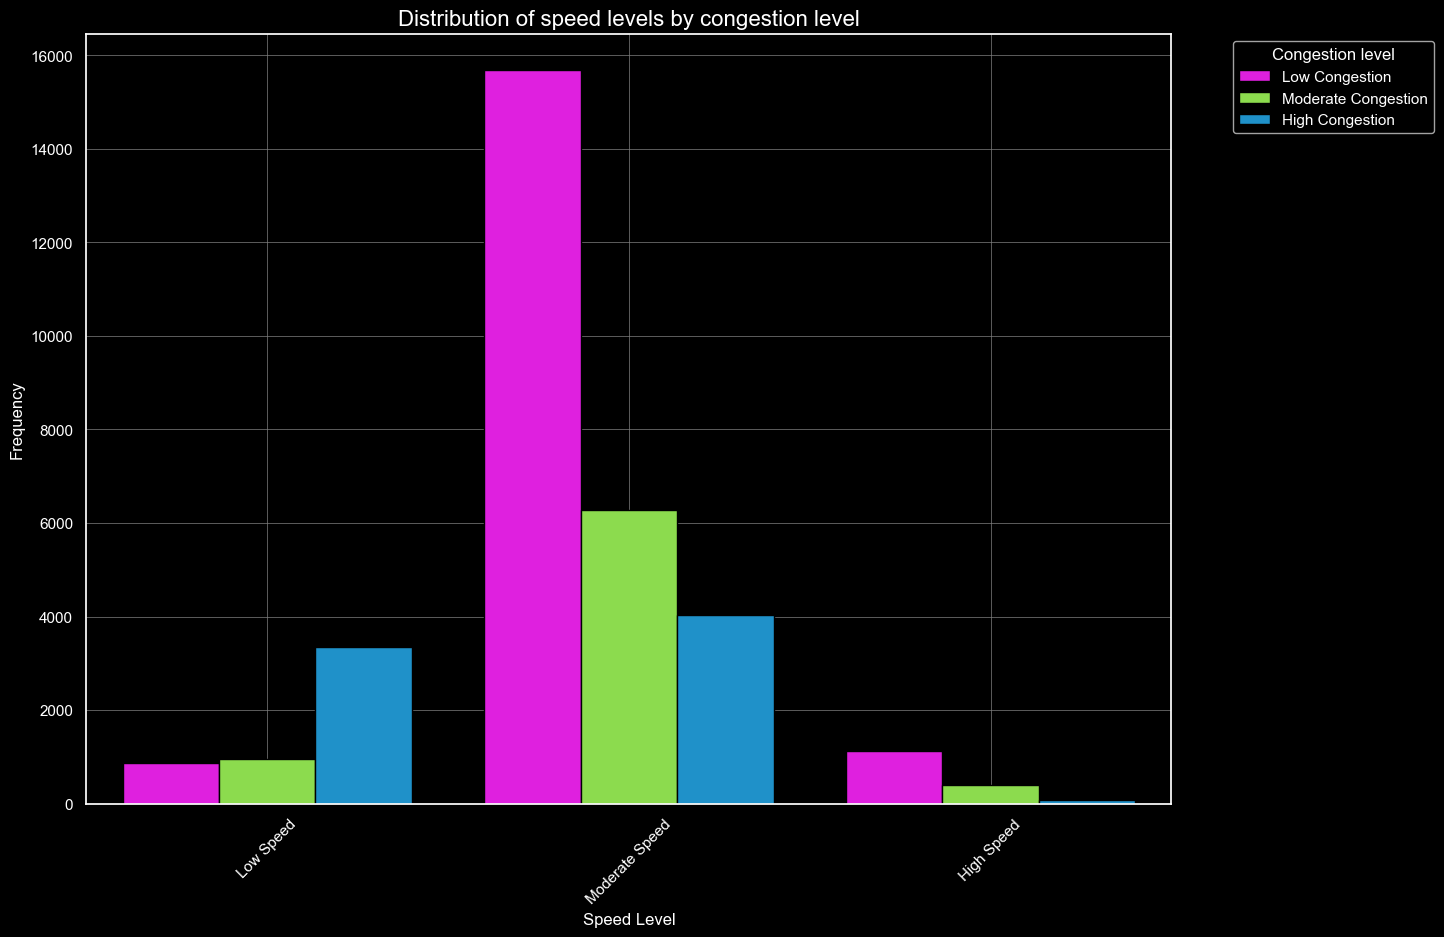

In [129]:
# Plot distribution of congestion levels
plt.figure(figsize=(14, 10))
vibrant_colors = ['#ff00ff', '#89f336', '#039BE5']
sns.countplot(data=df_merged, x='speed_level', hue='congestion_level', order=speed_labels, palette=vibrant_colors, edgecolor='black')
plt.title('Distribution of speed levels by congestion level',fontsize=16)
plt.xlabel('Speed Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Congestion level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()

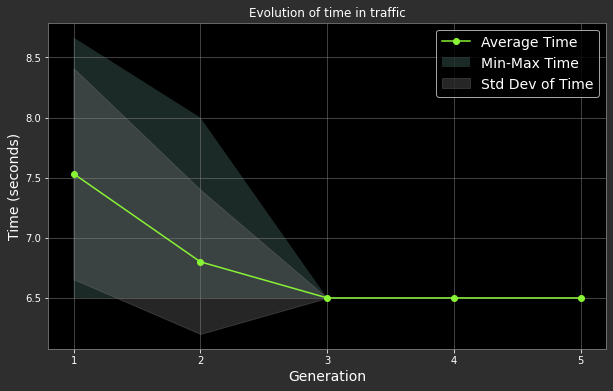

In [9]:
# Plot the evolutionary process for time
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('dark_background')

plt.plot(data['gen'], data['time_avg']/60, label='Average Time', marker='o',color='#89f336')
plt.fill_between(data['gen'], data['time_min']/60, data['time_max']/60, alpha=0.2, label='Min-Max Time')
plt.fill_between(data['gen'], (data['time_avg'] - data['time_std'])/60, (data['time_avg'] + data['time_std'])/60, color='grey', alpha=0.3, label='Std Dev of Time')
plt.xlabel('Generation', fontsize = 14)
plt.ylabel('Time (seconds)', fontsize = 14)
plt.title('Evolution of time in traffic')
plt.xticks(range(1,6))
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.legend(fontsize = 14)
plt.show()

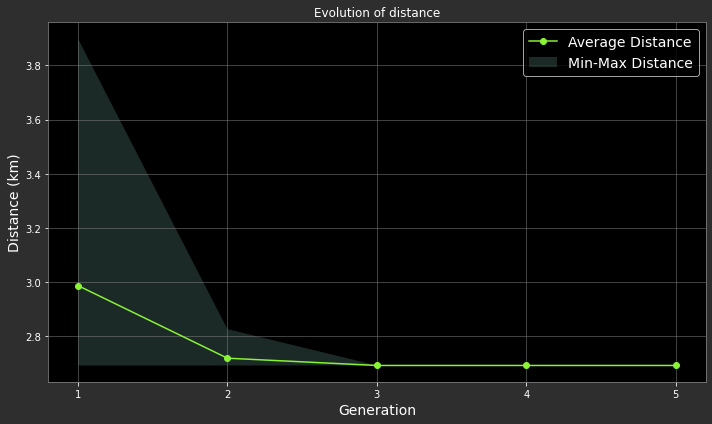

In [6]:
# Plot the evolutionary process for distance
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(data['gen'], data['distance_avg']/1000, label='Average Distance', marker='o',color='#89f336')
plt.fill_between(data['gen'], data['distance_min']/1000, data['distance_max']/1000, alpha=0.2, label='Min-Max Distance')
plt.xlabel('Generation', fontsize = 14)
plt.ylabel('Distance (km)', fontsize = 14)
plt.title('Evolution of distance')
plt.xticks(range(1,6))
plt.legend(fontsize = 14)

plt.tight_layout()
plt.grid(True, color='grey', linestyle='-', linewidth=0.5)  # Set grid color to grey
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.show()


In [77]:
df = pd.read_csv('C:\\Users\\Camelia\\Desktop\\my_django_project\\results\\ga_carierei\\evolution_statistics_route_276383106_to_262132793_5ind_5gen.csv')
df1=pd.read_csv('C:\\Users\\Camelia\\Desktop\\my_django_project\\results\\ga_carierei\\evolution_statistics_route_276383106_to_262132793_12ind_8gen.csv')
df2=pd.read_csv('C:\\Users\\Camelia\\Desktop\\my_django_project\\results\\ga_carierei\\evolution_statistics_route_276383106_to_262132793_25ind_10gen.csv')

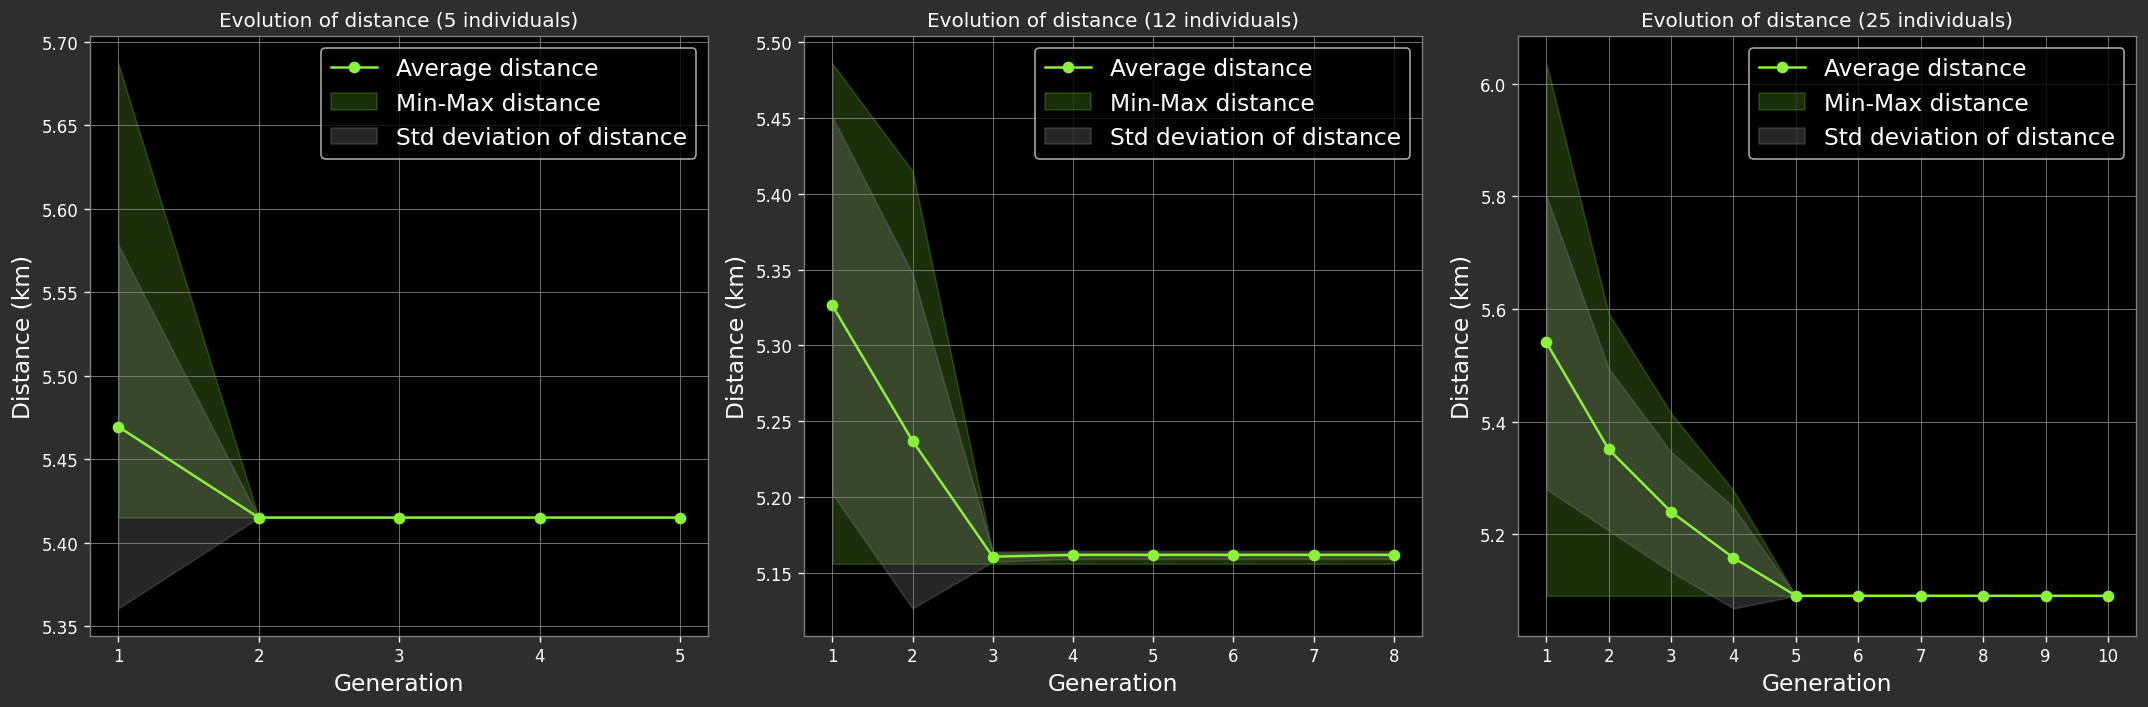

In [79]:
# Create a figure with 3 subplots in a row
fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=120)  # Increased figure size

ax[0].plot(df['gen'], df['distance_avg']/1000, label='Average distance', marker='o', color='#89f336')
ax[0].fill_between(df['gen'], df['distance_min']/1000, df['distance_max']/1000, alpha=0.2, color='#89f336', label='Min-Max distance')
ax[0].fill_between(df['gen'], (df['distance_avg'] - df['distance_std'])/1000, (df['distance_avg'] + df['distance_std'])/1000, color='grey', alpha=0.3, label='Std deviation of distance')
ax[0].set_xlabel('Generation', fontsize=14)
ax[0].set_ylabel('Distance (km)', fontsize=14)
ax[0].set_title('Evolution of distance (5 individuals)', fontsize=12)
ax[0].set_xticks(range(1, 6))
ax[0].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[0].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[0].spines['top'].set_color('grey')
ax[0].spines['right'].set_color('grey')
ax[0].spines['bottom'].set_color('grey')
ax[0].spines['left'].set_color('grey')
ax[0].legend(fontsize=14, loc='upper right')

ax[1].plot(df1['gen'], df1['distance_avg']/1000, label='Average distance', marker='o', color='#89f336')
ax[1].fill_between(df1['gen'], df1['distance_min']/1000, df1['distance_max']/1000, alpha=0.2, color='#89f336', label='Min-Max distance')
ax[1].fill_between(df1['gen'], (df1['distance_avg'] - df1['distance_std'])/1000, (df1['distance_avg'] + df1['distance_std'])/1000, color='grey', alpha=0.3, label='Std deviation of distance')
ax[1].set_xlabel('Generation', fontsize=14)
ax[1].set_ylabel('Distance (km)', fontsize=14)
ax[1].set_title('Evolution of distance (12 individuals)', fontsize=12)
ax[1].set_xticks(range(1, 9))
ax[1].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[1].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[1].spines['top'].set_color('grey')
ax[1].spines['right'].set_color('grey')
ax[1].spines['bottom'].set_color('grey')
ax[1].spines['left'].set_color('grey')
ax[1].legend(fontsize=14, loc='upper right')


ax[2].plot(df2['gen'], df2['distance_avg']/1000, label='Average distance', marker='o', color='#89f336')
ax[2].fill_between(df2['gen'], df2['distance_min']/1000, df2['distance_max']/1000, alpha=0.2, color='#89f336', label='Min-Max distance')
ax[2].fill_between(df2['gen'], (df2['distance_avg'] - df2['distance_std'])/1000, (df2['distance_avg'] + df2['distance_std'])/1000, color='grey', alpha=0.3, label='Std deviation of distance')
ax[2].set_xlabel('Generation', fontsize=14)
ax[2].set_ylabel('Distance (km)', fontsize=14)
ax[2].set_title('Evolution of distance (25 individuals)', fontsize=12)
ax[2].set_xticks(range(1, 11))
ax[2].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[2].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[2].spines['top'].set_color('grey')
ax[2].spines['right'].set_color('grey')
ax[2].spines['bottom'].set_color('grey')
ax[2].spines['left'].set_color('grey')
ax[2].legend(fontsize=14, loc='upper right')


plt.tight_layout()
plt.show()

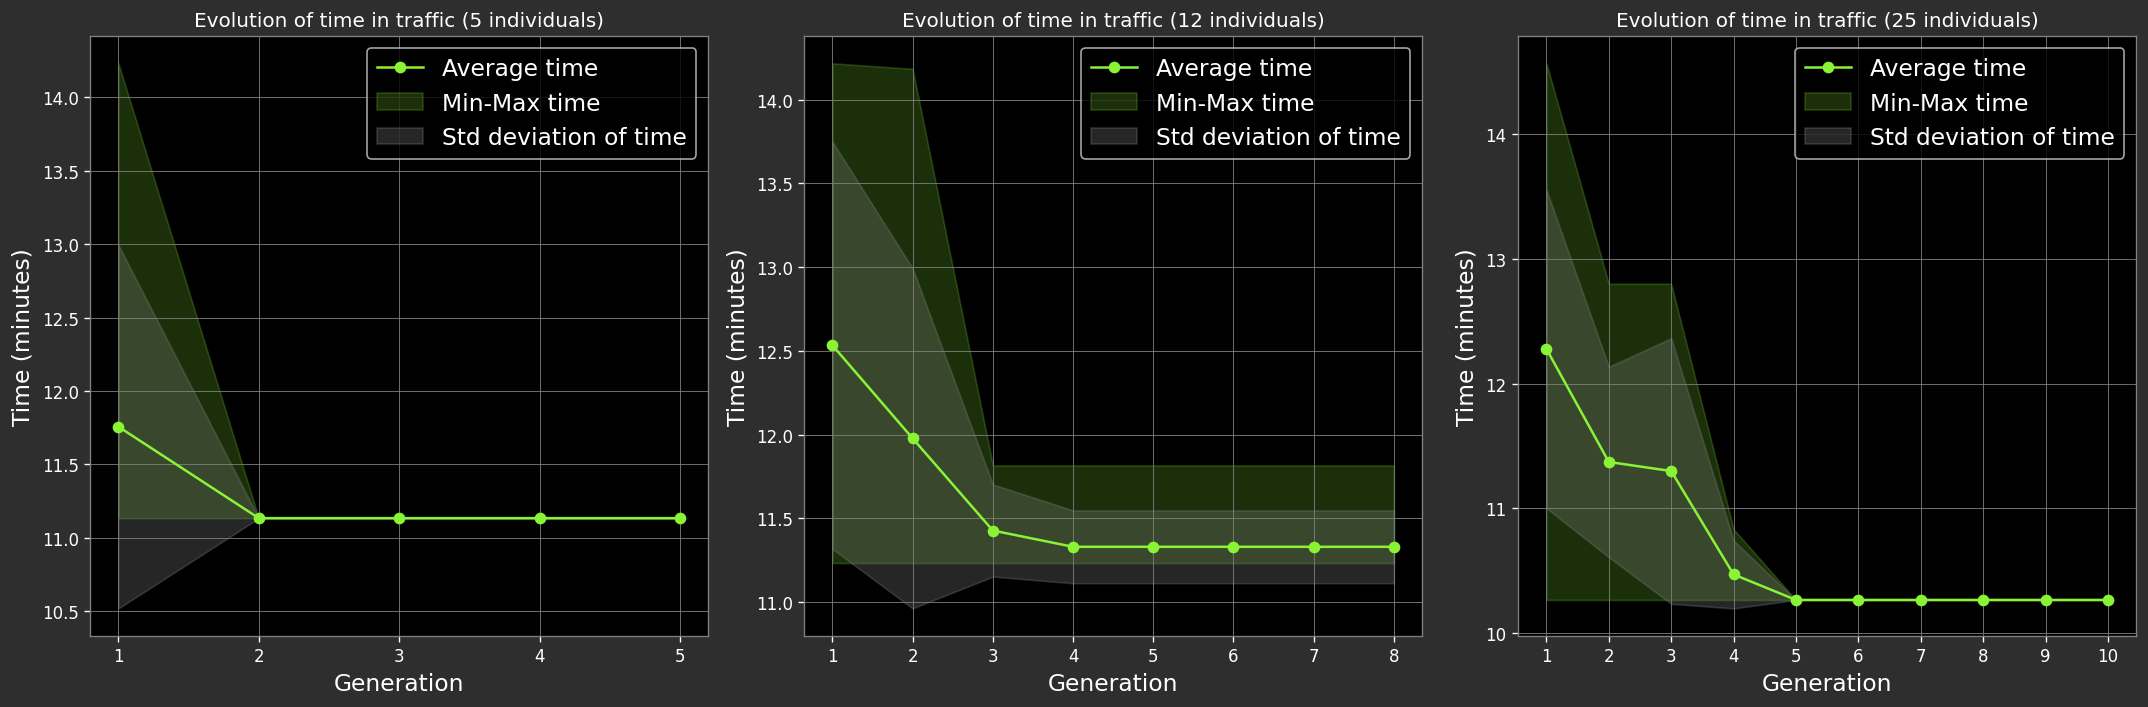

In [80]:
# Create a figure with 3 subplots in a row
fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=120)  # Increased figure size

ax[0].plot(df['gen'], df['time_avg']/60, label='Average time', marker='o', color='#89f336')
ax[0].fill_between(df['gen'], df['time_min']/60, df['time_max']/60, alpha=0.2, color='#89f336', label='Min-Max time')
ax[0].fill_between(df['gen'], (df['time_avg'] - df['time_std'])/60, (df['time_avg'] + df['time_std'])/60, color='grey', alpha=0.3, label='Std deviation of time')
ax[0].set_xlabel('Generation', fontsize=14)
ax[0].set_ylabel('Time (minutes)', fontsize=14)
ax[0].set_title('Evolution of time in traffic (5 individuals)', fontsize=12)
ax[0].set_xticks(range(1, 6))
ax[0].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[0].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[0].spines['top'].set_color('grey')
ax[0].spines['right'].set_color('grey')
ax[0].spines['bottom'].set_color('grey')
ax[0].spines['left'].set_color('grey')
ax[0].legend(fontsize=14, loc='upper right')

ax[1].plot(df1['gen'], df1['time_avg']/60, label='Average time', marker='o', color='#89f336')
ax[1].fill_between(df1['gen'], df1['time_min']/60, df1['time_max']/60, alpha=0.2, color='#89f336', label='Min-Max time')
ax[1].fill_between(df1['gen'], (df1['time_avg'] - df1['time_std'])/60, (df1['time_avg'] + df1['time_std'])/60, color='grey', alpha=0.3, label='Std deviation of time')
ax[1].set_xlabel('Generation', fontsize=14)
ax[1].set_ylabel('Time (minutes)', fontsize=14)
ax[1].set_title('Evolution of time in traffic (12 individuals)', fontsize=12)
ax[1].set_xticks(range(1, 9))
ax[1].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[1].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[1].spines['top'].set_color('grey')
ax[1].spines['right'].set_color('grey')
ax[1].spines['bottom'].set_color('grey')
ax[1].spines['left'].set_color('grey')
ax[1].legend(fontsize=14, loc='upper right')


ax[2].plot(df2['gen'], df2['time_avg']/60, label='Average time', marker='o', color='#89f336')
ax[2].fill_between(df2['gen'], df2['time_min']/60, df2['time_max']/60, alpha=0.2, color='#89f336', label='Min-Max time')
ax[2].fill_between(df2['gen'], (df2['time_avg'] - df2['time_std'])/60, (df2['time_avg'] + df2['time_std'])/60, color='grey', alpha=0.3, label='Std deviation of time')
ax[2].set_xlabel('Generation', fontsize=14)
ax[2].set_ylabel('Time (minutes)', fontsize=14)
ax[2].set_title('Evolution of time in traffic (25 individuals)', fontsize=12)
ax[2].set_xticks(range(1, 11))
ax[2].grid(True, color='grey', linestyle='-', linewidth=0.5)
# Styling axes
ax[2].set_facecolor('#000000')  # Grey background for the axes
fig.patch.set_facecolor('#2E2E2E') 
ax[2].spines['top'].set_color('grey')
ax[2].spines['right'].set_color('grey')
ax[2].spines['bottom'].set_color('grey')
ax[2].spines['left'].set_color('grey')
ax[2].legend(fontsize=14, loc='upper right')


plt.tight_layout()
plt.show()